In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Machine Learning**

###**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/abinaryclassification(naive bayes).csv")

In [ ]:
df.head()

,Tweet_id,Class,Sentence
0,1328,sadness,"#1: @idek ed ""My skin burns and is ugly. Make..."
1,1329,sadness,"#2: @🌹👻 ed ""@sad_adult Pardon my whining pls ..."
2,1330,sadness,"#3: @Kunjabihari panda ed ""@ANINewsUP This is..."
3,1331,sadness,"#4: @Ahmet UCAL ed ""RT @tgmcelebi: Bugün vata..."
4,1332,sadness,"#5: @☾ LILY ed ""RT @hoyaspop: I’m so sad.. ht..."


In [ ]:
df.drop(columns='Tweet_id', inplace=True)

In [ ]:
df.head()

,Class,Sentence
0,sadness,"#1: @idek ed ""My skin burns and is ugly. Make..."
1,sadness,"#2: @🌹👻 ed ""@sad_adult Pardon my whining pls ..."
2,sadness,"#3: @Kunjabihari panda ed ""@ANINewsUP This is..."
3,sadness,"#4: @Ahmet UCAL ed ""RT @tgmcelebi: Bugün vata..."
4,sadness,"#5: @☾ LILY ed ""RT @hoyaspop: I’m so sad.. ht..."


In [ ]:
df['Class'].value_counts()

Class
sadness      8014
happiness    7824
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Sentence'].shape)
print('Total Label : ', df['Class'].shape)

Total Data :  (15839,)
Total Label :  (15839,)


In [ ]:
df['Class'].unique()

array(['sadness', 'happiness', nan], dtype=object)

In [ ]:
df.isnull().sum()

Class       1
Sentence    1
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

Class       0
Sentence    0
dtype: int64

In [ ]:
df['Class'].unique()

array(['sadness', 'happiness'], dtype=object)

###**Dataset Visualization**

####**Total Data and Label**

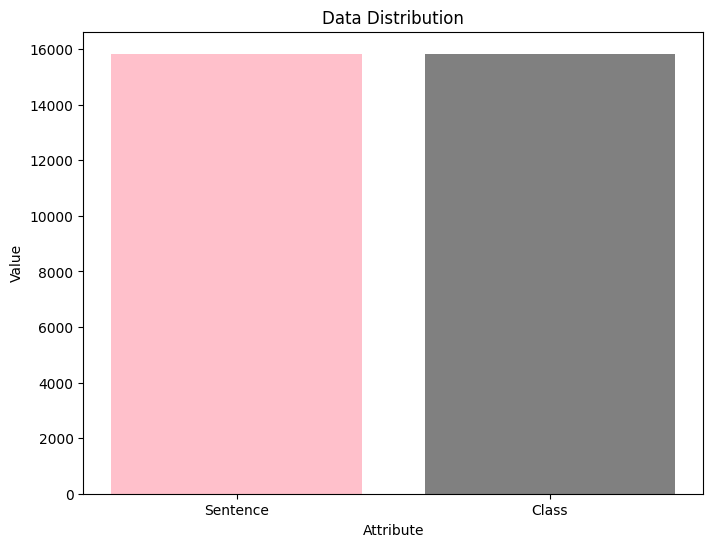

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(['Sentence', 'Class'], [df['Sentence'].shape[0], df['Class'].shape[0]], color = ['pink', 'grey'])
plt.title('Data Distribution')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.show()

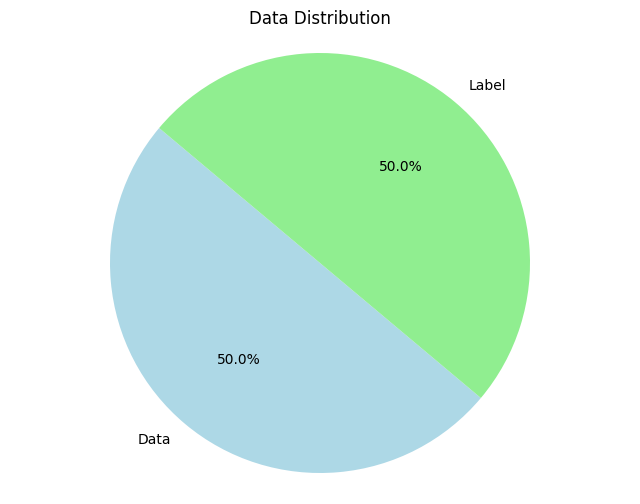

In [ ]:
plt.figure(figsize=(8, 6))
sizes = [df['Sentence'].shape[0], df['Class'].shape[0]]
labels = ['Data', 'Label']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors = ['lightblue', 'lightgreen'])
plt.axis('equal')
plt.title('Data Distribution')
plt.show()

####**Class Distribution of Target Variable**

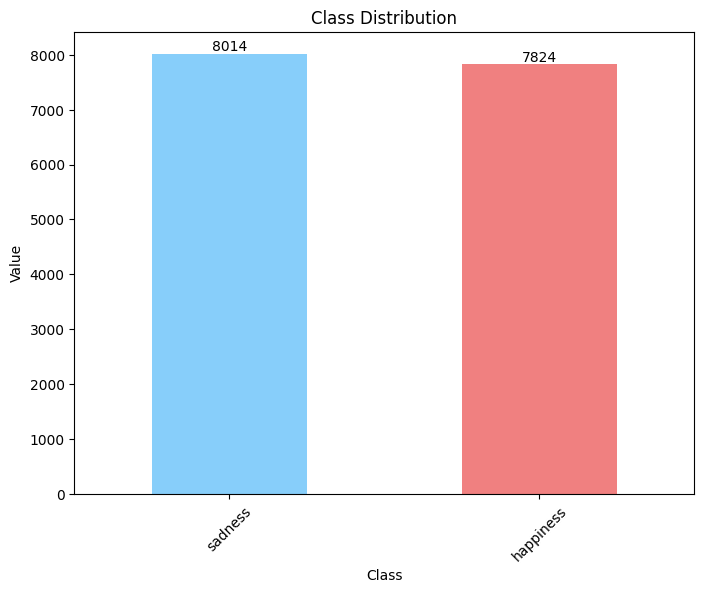

In [ ]:
import matplotlib.pyplot as plt

class_counts = df['Class'].value_counts()
colors = ['lightskyblue', 'lightcoral']

plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Value')
plt.xticks(rotation=45)

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


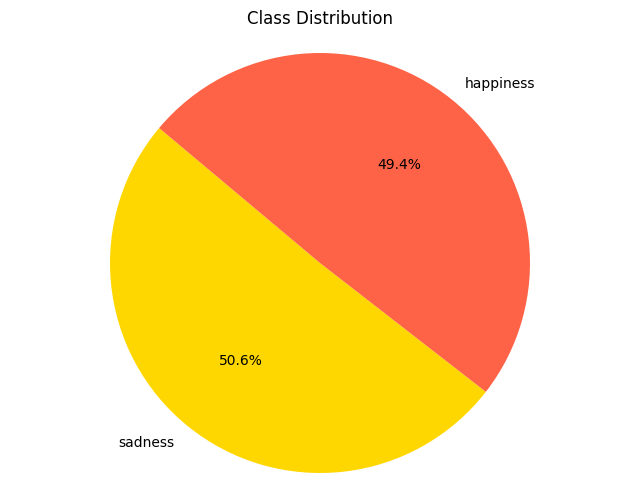

In [ ]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors = ['#FFD700', '#FF6347'])
plt.axis('equal')
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

###**Preprocessing**

1. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):
    if pd.isnull(text):
        return text
    text = text.lower()
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Sentence'] = df['Sentence'].apply(preprocess_text)
print(df.head())

     Class                                           Sentence
0  sadness     idek ed my skin burns and is ugly makes me sad
1  sadness  🌹👻 ed sadadult pardon my whining pls thank for...
2  sadness  kunjabihari panda ed aninewsup this is called ...
3  sadness  ahmet ucal ed rt tgmcelebi bugün vatan için şe...
4  sadness                     lily ed rt hoyaspop i’m so sad


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Sentence'] = df['Sentence'].apply(remove_emoji)
df.head()

,Class,Sentence
0,sadness,idek ed my skin burns and is ugly makes me sad
1,sadness,ed sadadult pardon my whining pls thank for l...
2,sadness,kunjabihari panda ed aninewsup this is called ...
3,sadness,ahmet ucal ed rt tgmcelebi bugün vatan için şe...
4,sadness,lily ed rt hoyaspop i’m so sad


###**Dependent and Independent Variable**

In [ ]:
X = df['Sentence']
y = df['Class']

###**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

###**Data Split (80:20)**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12670,) (3168,) (12670,) (3168,)


###**Feature Extraction using TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_padded =X_train_tfidf
X_test_padded =X_test_tfidf

###**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=209)
model.fit(X_train_padded, y_train)

RandomForestClassifier(n_estimators=209)

####**Accuracy**

In [ ]:
y_pred = model.predict(X_test_padded)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8352272727272727
Precision: 0.8356195690880511
Recall: 0.8352272727272727
F1-score: 0.8351982427115501


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.82      0.85      0.84      1575
         Sad       0.85      0.82      0.83      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



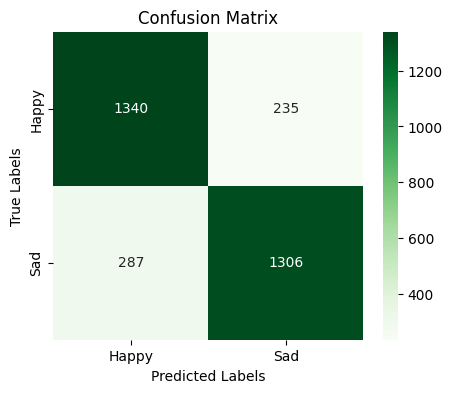

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

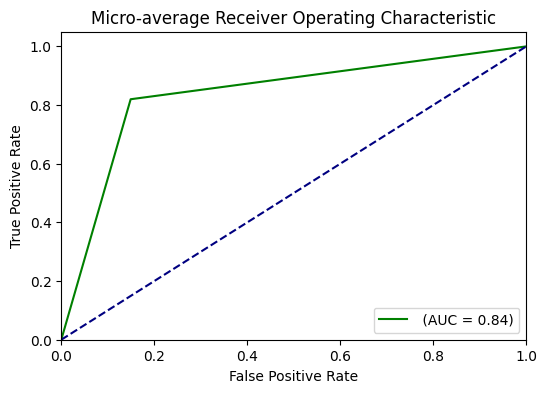

AUC =  0.8353152183660658


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = model.predict(X_test_padded)
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

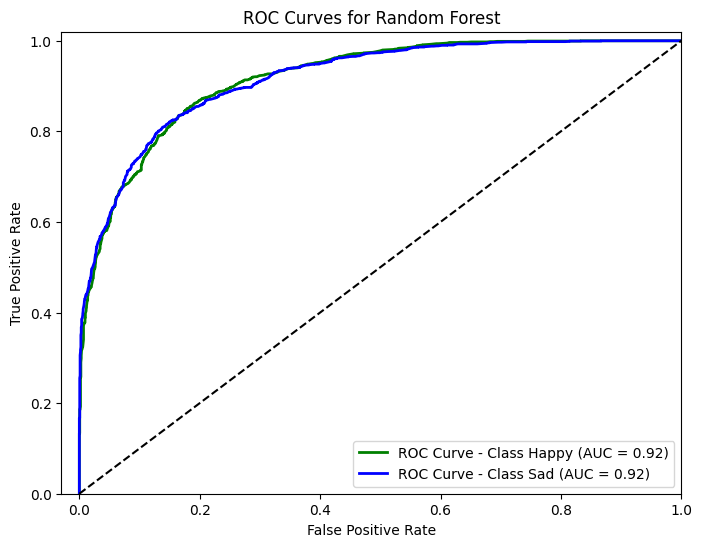

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest')
plt.legend(loc='lower right')
plt.show()

###**MNB**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_padded, y_train)

MultinomialNB()

####**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)



Accuracy: 0.8355429292929293
Precision: 0.8359211193699309
Recall: 0.8355429292929293
F1-score: 0.8355153480745402


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.82      0.85      0.84      1575
         Sad       0.85      0.82      0.83      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



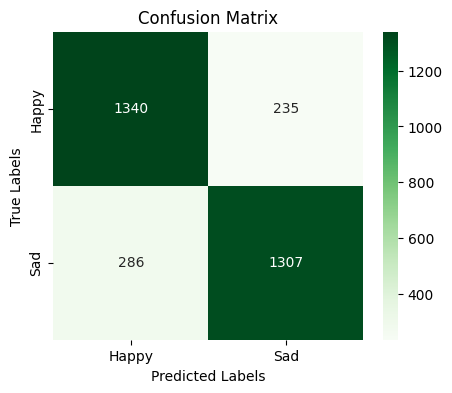

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

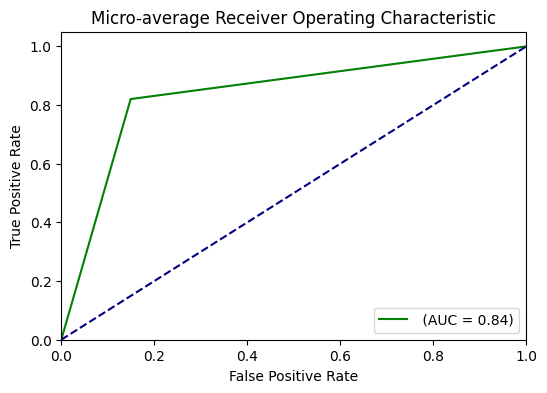

AUC =  0.835629091561295


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

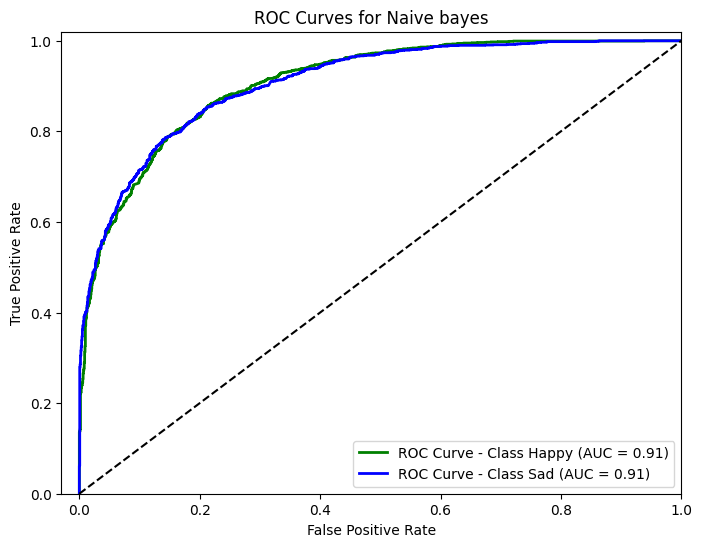

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Naive bayes')
plt.legend(loc='lower right')
plt.show()

###**SVM**

In [ ]:
from sklearn.svm import SVC

model = SVC(probability=True)
model.fit(X_train_padded, y_train)

SVC(probability=True)

####**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8194444444444444
Precision: 0.8196420342675212
Recall: 0.8194444444444444
F1-score: 0.819399092400951


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.83      0.86      0.85      1575
         Sad       0.86      0.83      0.84      1593

    accuracy                           0.85      3168
   macro avg       0.85      0.85      0.85      3168
weighted avg       0.85      0.85      0.85      3168



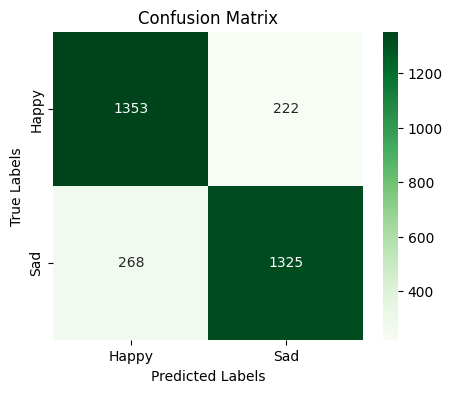

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

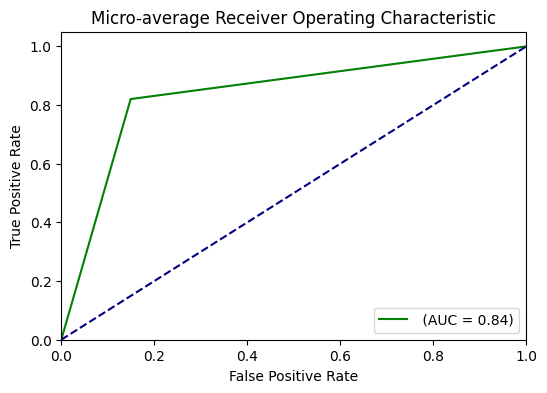

AUC =  0.835629091561295


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

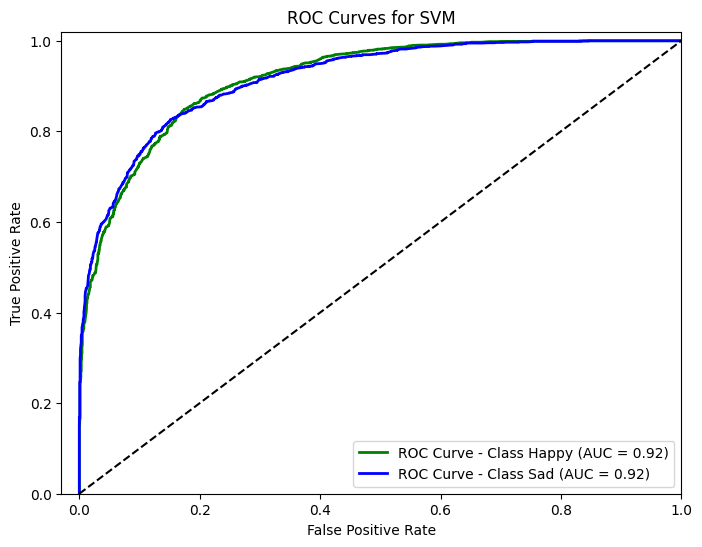

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM')
plt.legend(loc='lower right')
plt.show()

###**DT**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train_padded, y_train)

DecisionTreeClassifier()

####**Accuracy**

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8453282828282829
Precision: 0.8456452078421994
Recall: 0.8453282828282829
F1-score: 0.8453084314643449


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.77      0.78      0.77      1575
         Sad       0.78      0.77      0.77      1593

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168



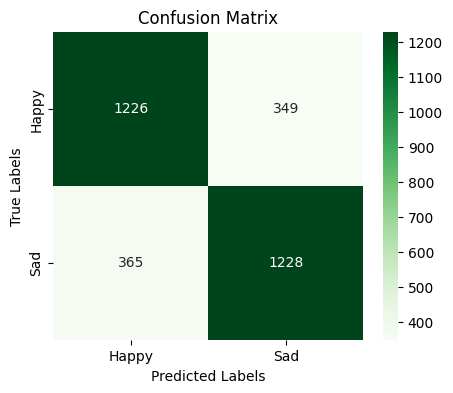

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

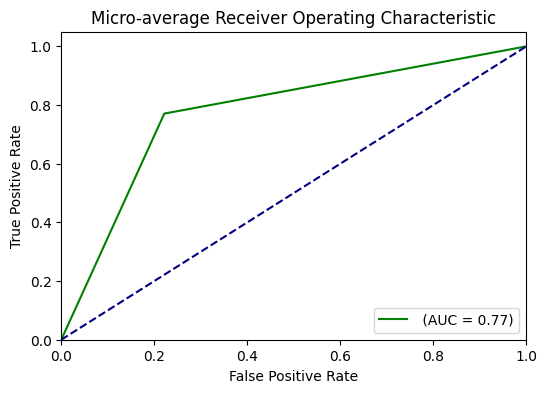

AUC =  0.7746426329477177


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

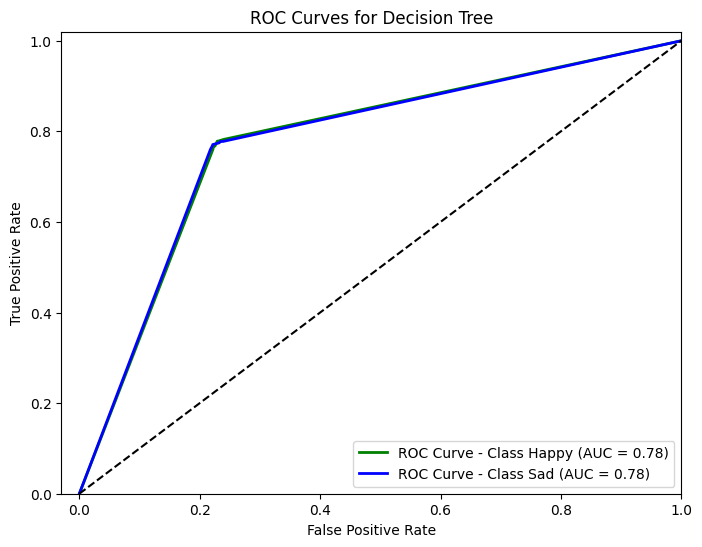

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree')
plt.legend(loc='lower right')
plt.show()

###**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_padded, y_train)

LogisticRegression()

####**Accuracy**

In [ ]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8273358585858586
Precision: 0.8274804599987562
Recall: 0.8273358585858586
F1-score: 0.827328925219213


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.82      0.84      0.83      1575
         Sad       0.83      0.82      0.83      1593

    accuracy                           0.83      3168
   macro avg       0.83      0.83      0.83      3168
weighted avg       0.83      0.83      0.83      3168



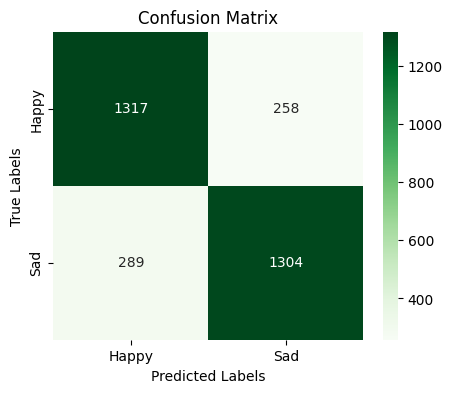

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

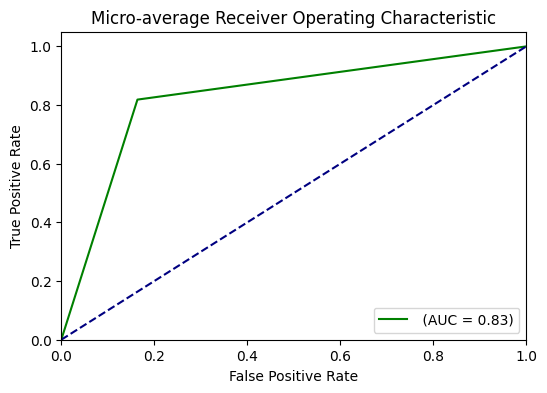

AUC =  0.8273858846740203


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

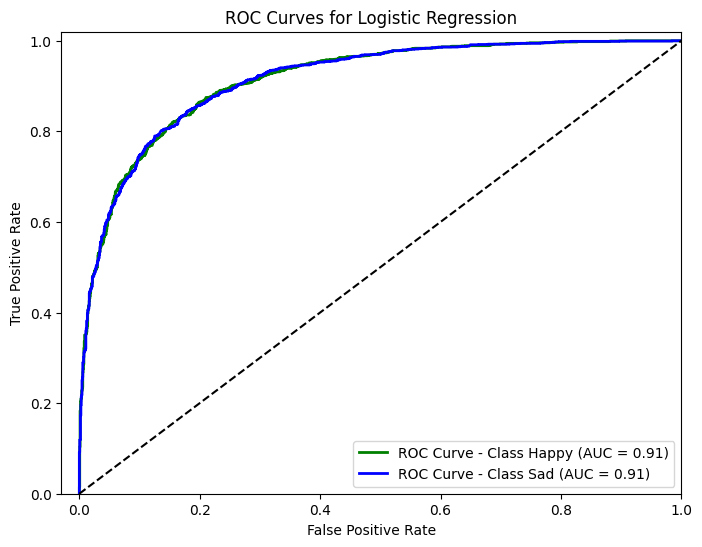

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

#**XGBoost**

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_padded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

####**Accuracy**

In [ ]:
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8428030303030303
Precision: 0.8432634722748609
Recall: 0.8428030303030303
F1-score: 0.8427696947290052


####**Classification Report and Confusion Matrix**

              precision    recall  f1-score   support

       Happy       0.79      0.87      0.83      1575
         Sad       0.86      0.78      0.82      1593

    accuracy                           0.82      3168
   macro avg       0.83      0.82      0.82      3168
weighted avg       0.83      0.82      0.82      3168



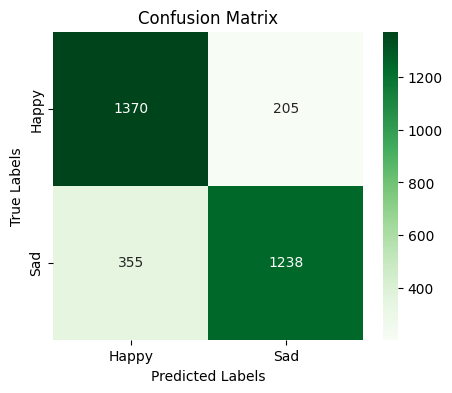

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**AUC Curve**

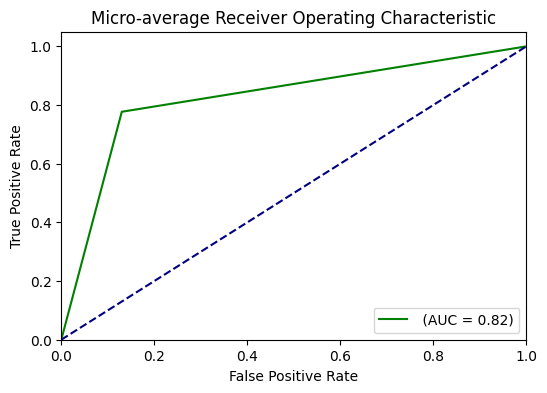

AUC =  0.8234956506142947


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


####**ROC Curve**

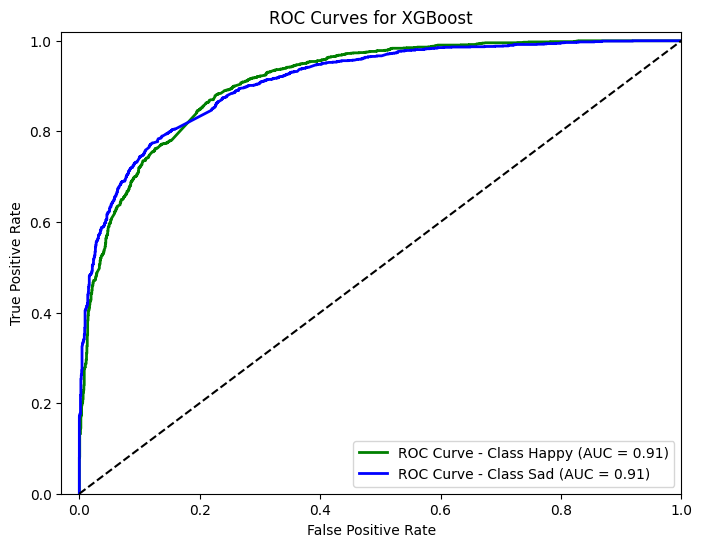

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (SVM + XGB + RF + MNB)**

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [ ]:
svm_classifier = SVC(probability=True)
xgb_classifier = XGBClassifier()
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
mnb_classifier = MultinomialNB()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('xgb', xgb_classifier),
    ('rf', rf_classifier),
    ('mnb', mnb_classifier)
], voting='soft')

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interactio...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('mnb', MultinomialNB())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.851010101010101
Precision: 0.8513308823484096
Recall: 0.851010101010101
F1-score: 0.8509909788799404


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.84      0.86      0.85      1575
         Sad       0.86      0.84      0.85      1593

    accuracy                           0.85      3168
   macro avg       0.85      0.85      0.85      3168
weighted avg       0.85      0.85      0.85      3168



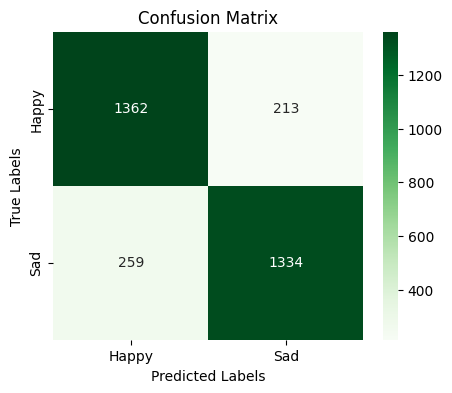

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

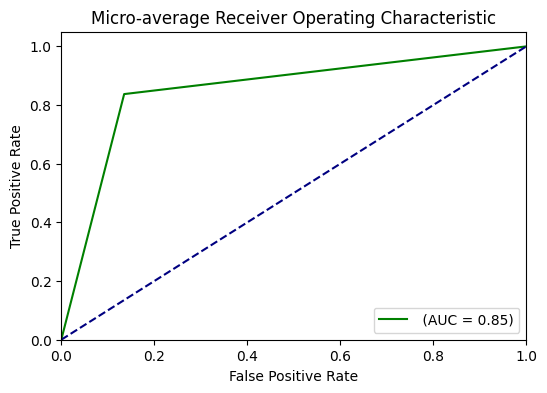

AUC =  0.8510877948166083


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

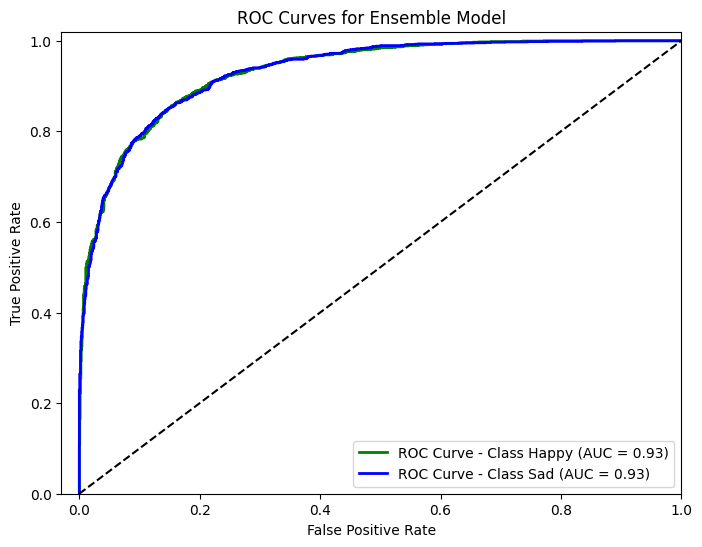

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (SVM + MNB)**

In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [ ]:
svm_classifier = SVC(probability=True)
mnb_classifier = MultinomialNB()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('mnb', mnb_classifier)
], voting='soft')

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('mnb', MultinomialNB())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8424873737373737
Precision: 0.8425473877834592
Recall: 0.8424873737373737
F1-score: 0.8424870755435313


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.84      0.85      0.84      1575
         Sad       0.85      0.84      0.84      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



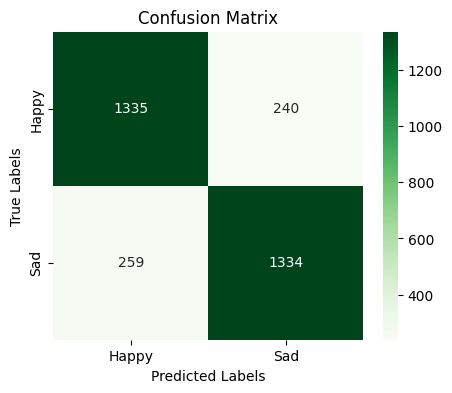

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

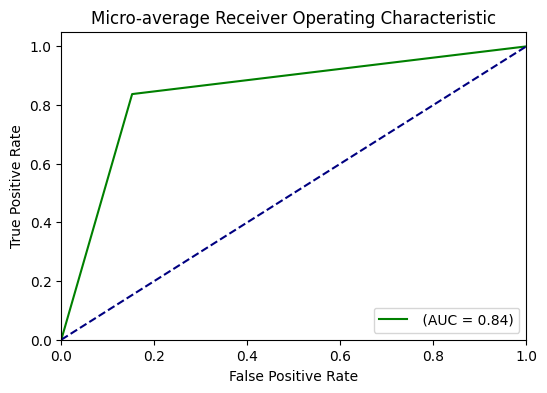

AUC =  0.8425163662451798


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

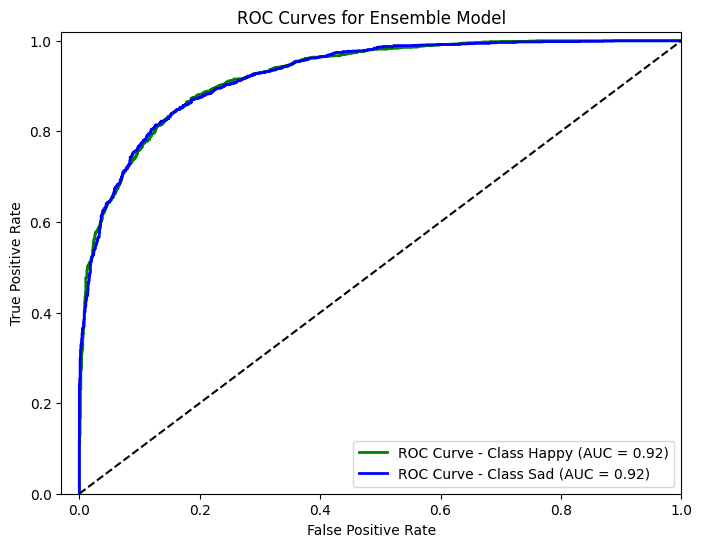

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (RF + DT)**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
dt_classifier = DecisionTreeClassifier()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('dt', dt_classifier)
], voting='soft')


In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('dt', DecisionTreeClassifier())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.7683080808080808
Precision: 0.7683896291104938
Recall: 0.7683080808080808
F1-score: 0.7683047564745428


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.76      0.77      0.77      1575
         Sad       0.77      0.76      0.77      1593

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168



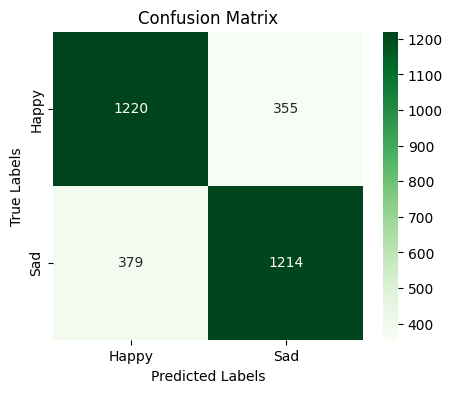

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

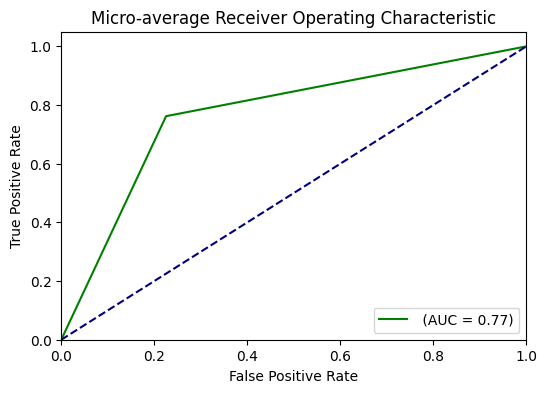

AUC =  0.768343646309748


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

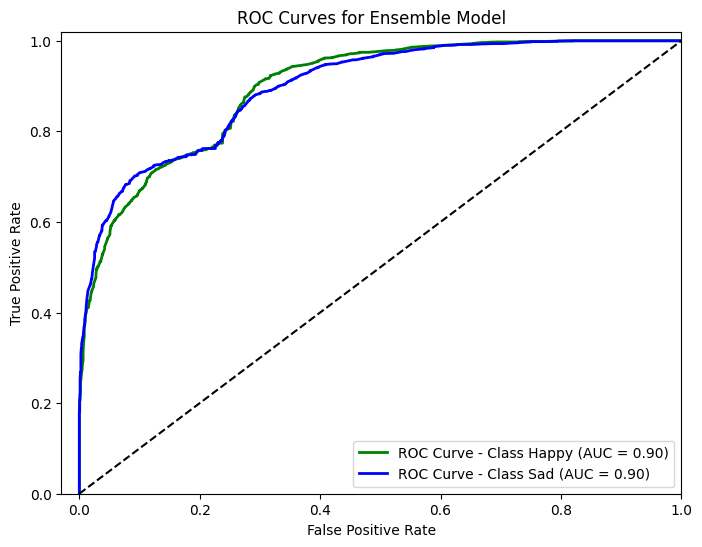

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (RF + MNB + LR)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [ ]:

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
mnb_classifier = MultinomialNB()
lr_classifier = LogisticRegression()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('mnb', mnb_classifier),
    ('lr', lr_classifier)
], voting='soft')

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('mnb', MultinomialNB()),
                             ('lr', LogisticRegression())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8421717171717171
Precision: 0.8422786381807188
Recall: 0.8421717171717171
F1-score: 0.8421684461713715


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.84      0.85      0.84      1575
         Sad       0.85      0.83      0.84      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



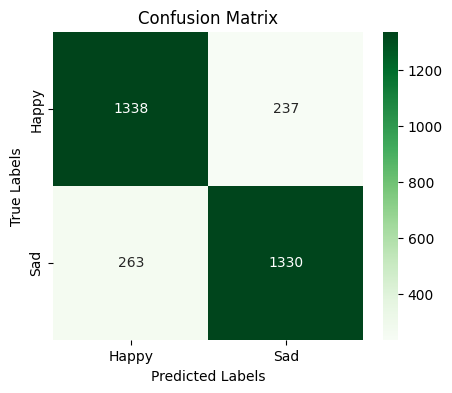

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

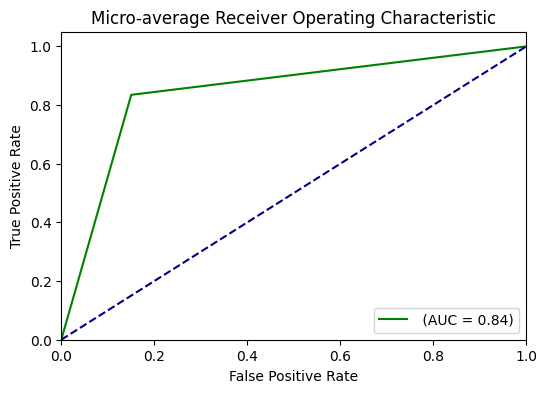

AUC =  0.8422132544166444


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

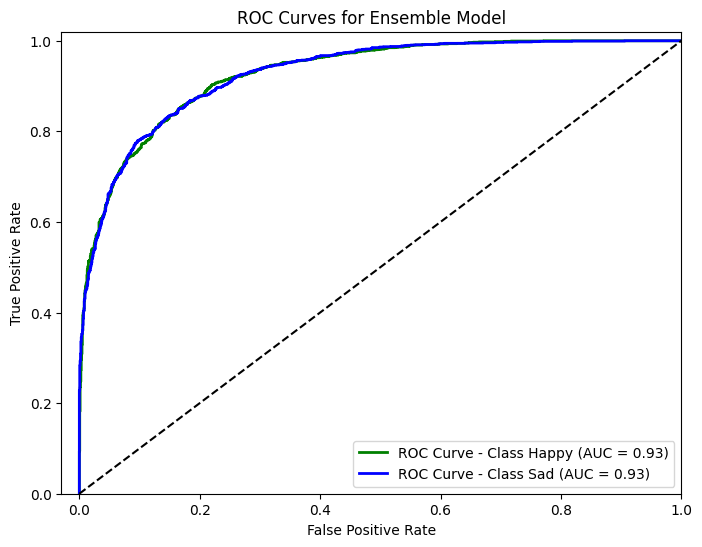

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (SVM + DT + LR)**

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [ ]:
svm_classifier = SVC(probability=True)
dt_classifier = DecisionTreeClassifier()
lr_classifier = LogisticRegression()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('dt', dt_classifier),
    ('lr', lr_classifier)
], voting='soft')

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('dt', DecisionTreeClassifier()),
                             ('lr', LogisticRegression())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8216540404040404
Precision: 0.8217970971134174
Recall: 0.8216540404040404
F1-score: 0.8216468788827338


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.81      0.83      0.82      1575
         Sad       0.83      0.81      0.82      1593

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.82      3168
weighted avg       0.82      0.82      0.82      3168



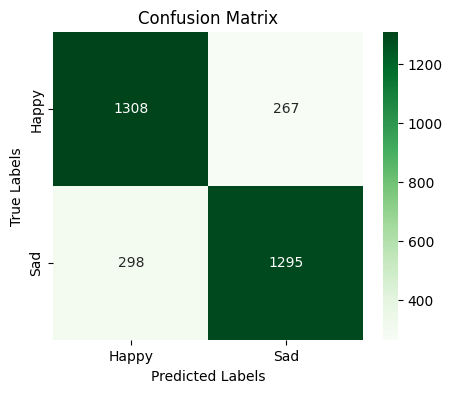

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

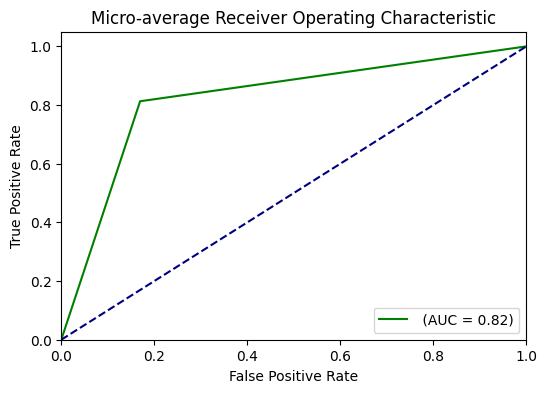

AUC =  0.8217038830598152


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

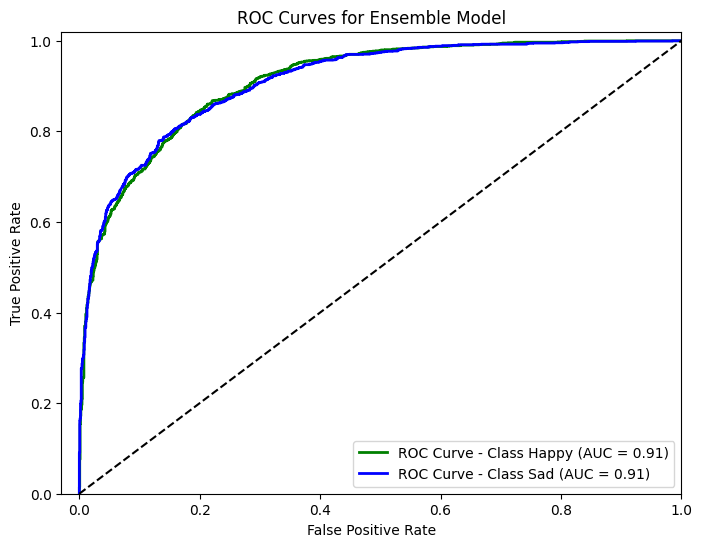

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# **Ensemble Learning (RF LR)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
lr_classifier = LogisticRegression()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('lr', lr_classifier)
], voting='soft')

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr', LogisticRegression())],
                 voting='soft')

### Accuracy

In [ ]:
y_pred = ensemble_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8428030303030303
Precision: 0.8432634722748609
Recall: 0.8428030303030303
F1-score: 0.8427696947290052


### Classification Report and Confusion Matirx

              precision    recall  f1-score   support

       Happy       0.83      0.86      0.84      1575
         Sad       0.86      0.83      0.84      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



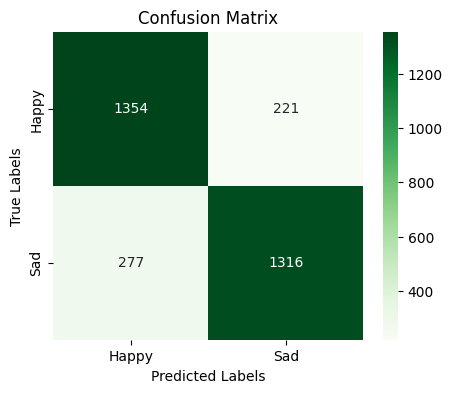

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (ensemble_model.predict(X_test_tfidf) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))
# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### AUC Curve

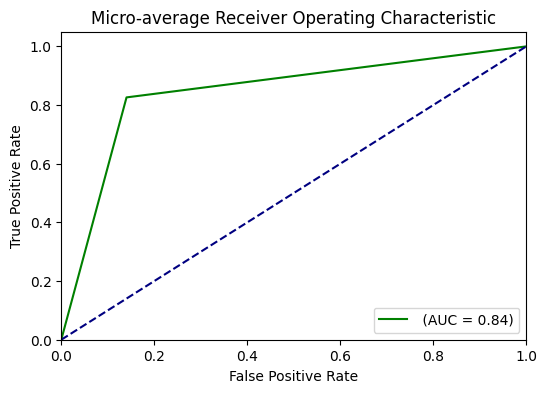

AUC =  0.8428983947628015


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model = ensemble_model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(predictions, classes=np.unique(y_test))


fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(6, 4))
plt.plot(fpr_micro, tpr_micro, label=f' (AUC = {roc_auc_micro:.2f})', color='Green')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC = ", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


### ROC Curve

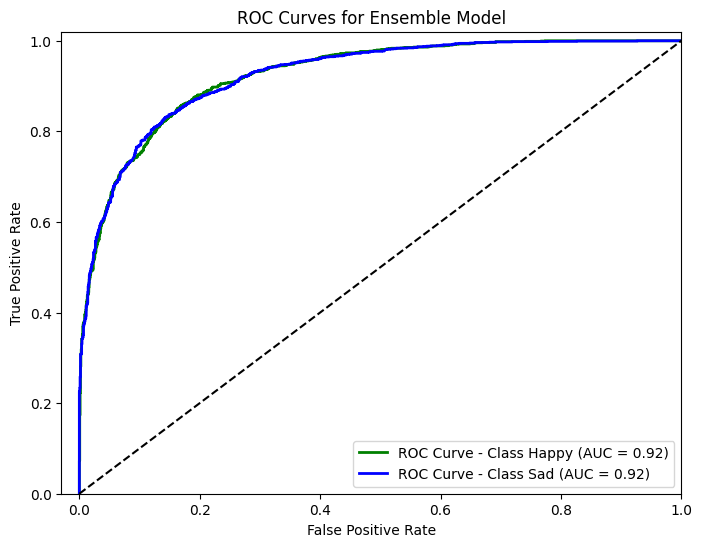

In [ ]:
y_probs = model.predict_proba(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'ROC Curve - Class Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'ROC Curve - Class Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Ensemble Model')
plt.legend(loc='lower right')
plt.show()